# COMPSCI 389: Introduction to Machine Learning
# Evaluation Re-Visited... Again

**Note:** This notebook is described in the slides, `10 Evaluation Part 3.pdf`. All of the important content within this notebook is in those slides, so you are not responsible for this notebook. However, you may reference this notebook to run the examples from the slides.

The code below should be review. It:
1. Imports the libraries we use
2. Defines the evaluation metrics we use
3. Defines the KNearestNeighbors model
4. Defines the WeightedKNearestNeighbors model

In [1]:
import pandas as pd
from sklearn.neighbors import KDTree
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

def mean_squared_error(predictions, labels):
    return np.mean((predictions - labels) ** 2)

def root_mean_squared_error(predictions, labels):
    return np.sqrt(mean_squared_error(predictions, labels))

def mean_absolute_error(predictions, labels):
    return np.mean(np.abs(predictions - labels))

def r_squared(predictions, labels):
    ss_res = np.sum((labels - predictions) ** 2)        # ss_res is the "Sum of Squares of Residuals"
    ss_tot = np.sum((labels - np.mean(labels)) ** 2)    # ss_tot is the "Total Sum of Squares"
    return 1 - (ss_res / ss_tot)

class KNearestNeighbors(BaseEstimator):
    # Add a constructor that stores the value of k (a hyperparameter)
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        # Convert X and y to NumPy arrays if they are DataFrames
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values

        # Store the training data and labels
        self.X_data = X
        self.y_data = y
        
        # Create a KDTree for efficient nearest neighbor search
        self.tree = KDTree(X)

        return self

    def predict(self, X):
        # Convert X to a NumPy array if it's a DataFrame
        if isinstance(X, pd.DataFrame):
            X = X.values

        # Query the tree for the k nearest neighbors for all points in X
        dist, ind = self.tree.query(X, k=self.k)

        # Return the average label for the nearest neighbors of each query
        return np.mean(self.y_data[ind], axis=1)
    
class WeightedKNearestNeighbors(BaseEstimator):
    # Add a constructor that stores the value of k and sigma (hyperparameters)
    def __init__(self, k=3, sigma=1.0):
        self.k = k
        self.sigma = sigma

    def fit(self, X, y):
        # Convert X and y to NumPy arrays if they are DataFrames
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values

        # Store the training data and labels
        self.X_data = X
        self.y_data = y
        
        # Create a KDTree for efficient nearest neighbor search
        self.tree = KDTree(X)

        return self

    def gaussian_kernel(self, distance):
        # Gaussian kernel function
        return np.exp(- (distance ** 2) / (2 * self.sigma ** 2))

    def predict(self, X):
        # Convert X to a NumPy array if it's a DataFrame
        if isinstance(X, pd.DataFrame):
            X = X.values

        # We will iteratively load predictions, so it starts empty
        predictions = []
        
        # Loop over rows in the query
        for x in X:
            # Query the tree for the k nearest neighbors
            dist, ind = self.tree.query([x], k=self.k)

            # Calculate weights using the Gaussian kernel
            weights = self.gaussian_kernel(dist[0])

            # Check if weights sum to zero. This happens when all points are very far, giving weights that round to zero, causing divison by zero later. In this case, revert to un-weighted (all weights are one).
            if np.sum(weights) == 0:
                # If weights sum to zero, assign equal weight to all neighbors
                weights = np.ones_like(weights)

            # Weighted average of the labels of the k nearest neighbors
            weighted_avg_label = np.average(self.y_data[ind[0]], weights=weights)
            predictions.append(weighted_avg_label)

        # Return the array of predictions we have created
        return np.array(predictions)

Let's run NearestNeighbor, evaluating using different amounts of test data (from 5% of the test data to 100% of the test data). We will run this several times to visualize how the sample MSE varies across runs.

First load the data set, split it (with most points for evaluation this time), and train a model to get a single model that we will evaluate. Then get the predictions and errors on the testing set.

In [ ]:
# Load the data set
df = pd.read_csv("data/GPA.csv", delimiter=',')

# We already loaded X and y, but do it again as a reminder
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split the data into training and testing sets (20% train, 80% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=True) # Let's use most of the data for evalution in this case

# Train the NearestNeighbor model
model = KNearestNeighbors(k=1)
model.fit(X_train, y_train)

# Compute predictions for X_test
predictions = model.predict(X_test)

# Compute the sample squared errors
squared_errors = (predictions - y_test) ** 2
display("Squared errors: ", squared_errors)

'Squared errors: '

4235     0.024545
24036    3.712057
2760     0.000278
17666    0.017777
3382     1.496536
           ...   
34459    0.170842
14526    2.667767
20521    1.102500
40100    0.041343
28412    0.384400
Name: gpa, Length: 34643, dtype: float64

## Model Evaluation

Let's consider the problem of evaluating the mean squared error (MSE) of this one model that we have learned. This is independent of the method used to train this model (it could have come from anywhere).

Let's create a function that takes in a variable `percentage`, and which then computes the sample MSE from only `percentage`% of the provided squared errors.

In [3]:
# Function to compute average MSE for a given percentage of squared errors
def compute_average_mse(percentage, squared_errors):
    # Get the number of samples that we should use from squared_errors
    subset_size = int(percentage * len(squared_errors))

    # Randomly select that many indices (without replacement)
    indices = np.random.choice(len(squared_errors), subset_size, replace=False)

    # Get the average of the squared errors at the selected indices
    average_mse = squared_errors.iloc[indices].mean()
    
    return average_mse

Now let's use this to plot the sample MSE using different amounts of the test data. This simulates what we would see if we had different amounts of data in the test set.

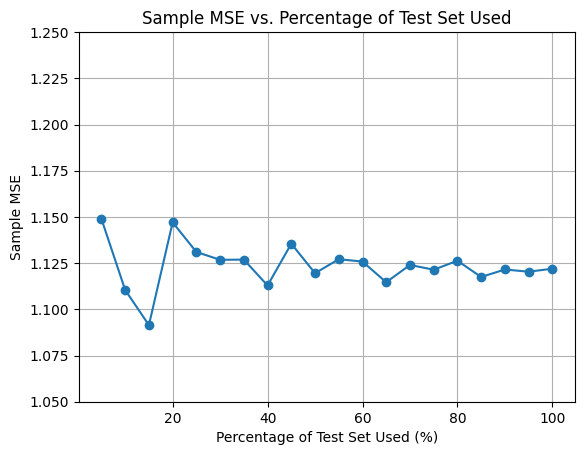

In [19]:
# Percentages to test, from 5% to 100% in increments of 5%
percentages = np.arange(0.05, 1.05, 0.05)

# Compute average MSE values for each percentage
average_mse_values = [compute_average_mse(p, squared_errors) for p in percentages]

# Plotting
plt.plot(percentages * 100, average_mse_values, marker='o')
plt.ylim(1.05, 1.25)
plt.xlabel('Percentage of Test Set Used (%)')
plt.ylabel('Sample MSE')
plt.title('Sample MSE vs. Percentage of Test Set Used')
plt.grid(True)
plt.show()

If we run the block above a few times, we see significant variation in the sample MSEs.

Let's overlay many runs of this plot:

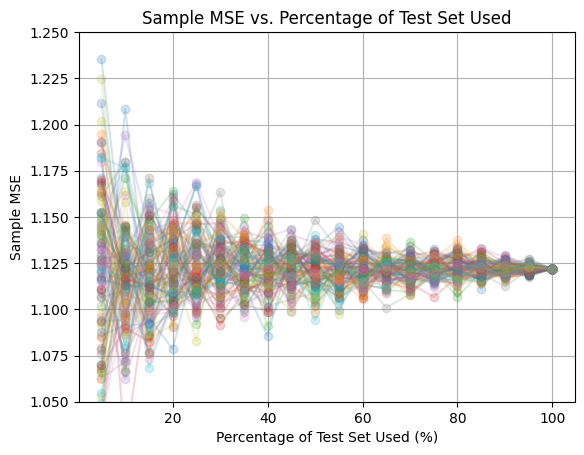

In [5]:
# Plotting 100 times
for _ in range(100):
    average_mse_values = [compute_average_mse(p, squared_errors) for p in percentages]
    plt.plot(percentages * 100, average_mse_values, marker='o', alpha=0.2)  # alpha for transparency

plt.ylim(1.05, 1.25)  # Setting y-axis limits
plt.xlabel('Percentage of Test Set Used (%)')
plt.ylabel('Sample MSE')
plt.title('Sample MSE vs. Percentage of Test Set Used')
plt.grid(True)
plt.show()


The tables that we presented before were showing single points from these plots! The plot above gives us an idea how much the predictions vary, and hence how much we should trust them.

Let's capture this using error bars that show the standard error for each point. Notice that we can do this from a single run (we don't require 100 runs with different test sets).

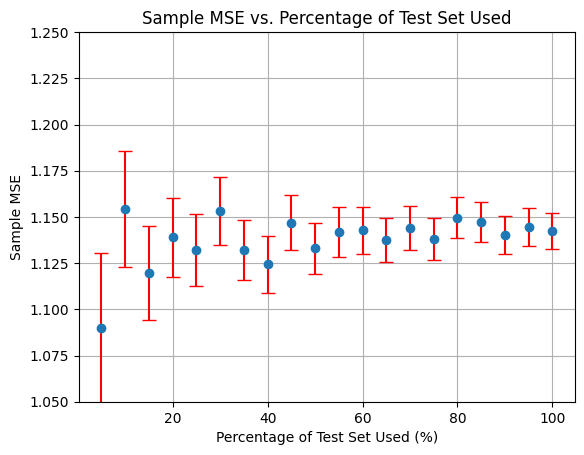

In [25]:
# Modified function to also compute standard error
def compute_average_mse_and_std_error(percentage, squared_errors):
    subset_size = int(percentage * len(squared_errors))
    indices = np.random.choice(len(squared_errors), subset_size, replace=False)
    subset_errors = squared_errors.iloc[indices]
    average_mse = subset_errors.mean()
    std_error = subset_errors.std() / np.sqrt(subset_size)  # Standard error
    return average_mse, std_error

# Percentages to test
percentages = np.arange(0.05, 1.05, 0.05)

# Compute average MSE values and standard errors for each percentage
average_mse_values, std_errors = zip(*[compute_average_mse_and_std_error(p, squared_errors) for p in percentages])

# Plotting with error bars
plt.errorbar(percentages * 100, average_mse_values, yerr=std_errors, fmt='o', ecolor='red', capsize=5)
plt.ylim(1.05, 1.25)
plt.xlabel('Percentage of Test Set Used (%)')
plt.ylabel('Sample MSE')
plt.title('Sample MSE vs. Percentage of Test Set Used')
plt.grid(True)
plt.show()


Running the code above a few times, we see that it captures how we should trust earlier points less... but it seems to be a bit over-confidenct, suggesting the true values are closer to the points than they really are.

We can view these error bars as providing a 95% confidence interval, **however**:
- This assumes that the squared errors are normally distributed.
- The confidence interval is 1.96 times the error bar width.
- The confidence interval should only contain the true MSE (**seemingly** just below 1.150) 95% of the time.
    - We'll come back to this "seemingly" later.

Let's investigate each of these a little more. First, are the squared errors normally distributed?

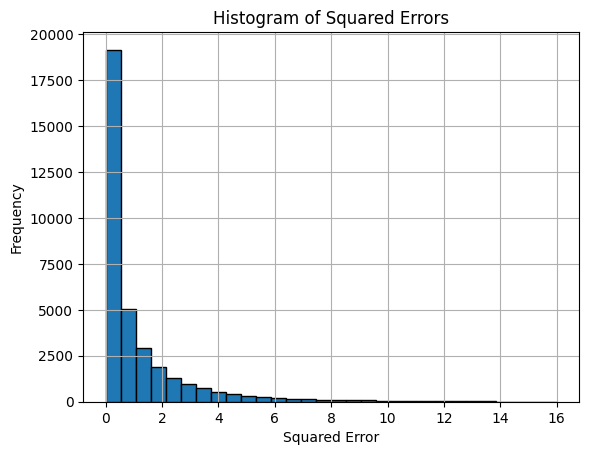

In [7]:
# Creating a histogram of the squared errors
plt.hist(squared_errors, bins=30, edgecolor='black')
plt.xlabel('Squared Error')
plt.ylabel('Frequency')
plt.title('Histogram of Squared Errors')
plt.grid(True)
plt.show()

Yikes, the squared errors are **not** normally distributed. We can still use error bars based on standard deviation, but we should be cautious how much we trust them.

**Note (this is for your information, but you will not be tested on it)**: By the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem), the sample mean of any random variable becomes normally distributed as the nmber of samples increases. Also, the reliability of the confidence interval from standard error is related to how close to normally distributed the sample mean is, not each individual sample. So, as the number of samples grows, these error bars should become more and more reliable. You may see texts saying that for more than ~30 samples the central limit theorem kicks in and these normality assumptions are reasonable. That may be true in some cases where samples are already roughly normally distributed (e.g., measurements of quantities in the real-world), but it is often **not** true in ML applications where distributions can be extremely far from normal.

We've investigated the first of the three bullets:
- This assumes that the squared errors are normally distributed.
- The confidence interval is 1.96 times the error bar width.
- The confidence interval should only contain the true MSE (**seemingly** just below 1.150) 95% of the time.

Now, let's investigate the second by scaling the error bars by a factor of 1.96.

**Note: ML texts usually do NOT do this! You must do this in your head!**

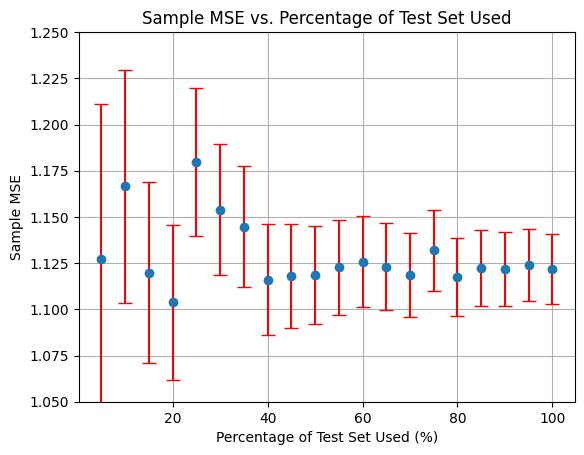

In [8]:
# Inflate the error bars
inflated_std_errors = [1.96 * se for se in std_errors]

# Replot
plt.errorbar(percentages * 100, average_mse_values, yerr=inflated_std_errors, fmt='o', ecolor='red', capsize=5)
plt.ylim(1.05, 1.25)
plt.xlabel('Percentage of Test Set Used (%)')
plt.ylabel('Sample MSE')
plt.title('Sample MSE vs. Percentage of Test Set Used')
plt.grid(True)
plt.show()

If you run the plot above a few times, you'll see that it does tend to include the apparent MSE of just below 1.150 in most cases!

We can also overlay this on our previous plot to see how it captures the variation. Note, however, that the error bars are meant to include the true MSE with probability 0.95. They aren't necessarily meant to capture the range of curves that we see. That is, if the sample MSE is below the true MSE, the error bar should be big enough to reach up to the true MSE 95% of the time, but need not reach up to include 95% of the sample MSEs that we observe.

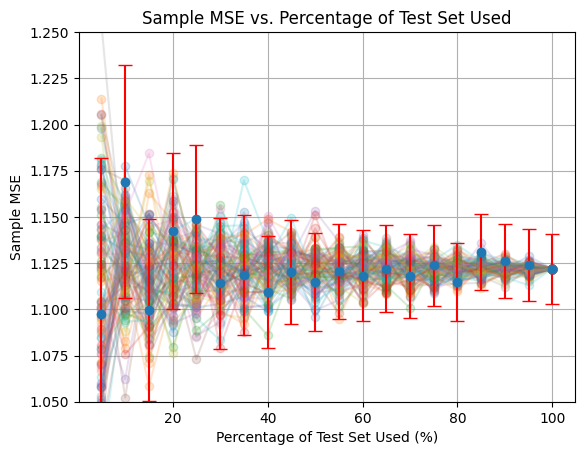

In [9]:
# Plotting 100 times
for _ in range(100):
    average_mse_values = [compute_average_mse(p, squared_errors) for p in percentages]
    plt.plot(percentages * 100, average_mse_values, marker='o', alpha=0.2)  # alpha for transparency

plt.errorbar(percentages * 100, average_mse_values, yerr=inflated_std_errors, fmt='o', ecolor='red', capsize=5)
plt.ylim(1.05, 1.25)

plt.ylim(1.05, 1.25)  # Setting y-axis limits
plt.xlabel('Percentage of Test Set Used (%)')
plt.ylabel('Sample MSE')
plt.title('Sample MSE vs. Percentage of Test Set Used')
plt.grid(True)
plt.show()


If you run the code above many times, you'll see that the error bars do tend to cover the values that we sample.

Notice that the error bars are still fairly wide even at 100% of the data.

**Question**: Why?

**Answer**: This relates to the "seemingly" statement about the true MSE being between 1.125 and 1.15. Even when using 100% Of the data, we're still computing a **sample** MSE. All of our 100 trials will get the exact same value, since they just use all 34,643 points in the testing set, making it look like there is no variance in the MSE when using 100% of the test set. If we had even more data, then the sample MSEs that we saw with 34,943 points (100% in the plot above) would still have variance. The error bars are better here, showing that even with 100% of the testing data we have significant uncertainty about the actual MSE!

**Question**: If the squared errors really were normally distributed, is the guarantee that the true MSE is within all of the (inflated by x1.96) confidence intervals with probability at least 0.95? Or is the guarantee that, if we were to pick any one point and its error bar (before looking at the data), that one error bar will hold the true MSE with probability at least 0.95?

**Answer**: The latter. Each error bar can fail with probability 0.05. The chance that one or more error bar does not include the true MSE can be much larger than 5%.

Let's revisit the table we made, comparing nearest neighbor variants:

In [10]:
# Load the data set
df = pd.read_csv("data/GPA.csv", delimiter=',')

# We already loaded X and y, but do it again as a reminder
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split the data into training and testing sets (60% train, 40% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=True)

# Model parameters to test
parameters = [
    {"k": 1, "sigma": None},    # Standard NN
    {"k": 100, "sigma": None},  # Standard k-NN
    {"k": 110, "sigma": 90}   # Weighted k-NN
]

# Dictionary to store results
results = []

# Training and evaluating each model
for param in parameters:
    if param["sigma"] is None:
        model = KNearestNeighbors(k=param["k"])
    else:
        model = WeightedKNearestNeighbors(k=param["k"], sigma=param["sigma"])
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mse = mean_squared_error(predictions, y_test)
    rmse = root_mean_squared_error(predictions, y_test)
    mae = mean_absolute_error(predictions, y_test)
    r2 = r_squared(predictions, y_test)

    results.append({"Model": f"k-NN k={param['k']} sigma={param['sigma']}", 
                    "MSE": mse, "RMSE": rmse, "MAE": mae, "R^2": r2})

# Creating DataFrame for results
results_df = pd.DataFrame(results)

# Finding the best (minimum or maximum) values for each metric
best_metrics = {
    "MSE": results_df['MSE'].idxmin(),
    "RMSE": results_df['RMSE'].idxmin(),
    "MAE": results_df['MAE'].idxmin(),
    "R^2": results_df['R^2'].idxmax()
}

# Highlighting the best values in the DataFrame
def highlight_best(row, best_metrics):
    return ['font-weight: bold' if (col in best_metrics and row.name == best_metrics[col]) else '' for col in row.index]

# Apply the highlighting
styled_results = results_df.style.apply(highlight_best, best_metrics=best_metrics, axis=1)
styled_results

,Model,MSE,RMSE,MAE,R^2
0,k-NN k=1 sigma=None,1.066188,1.032564,0.793455,-0.635682
1,k-NN k=100 sigma=None,0.556796,0.746187,0.587380,0.145797
2,k-NN k=110 sigma=90,0.555601,0.745386,0.586671,0.147631


Recall that running this many times resulted in different conclusions about which method was the best.

This is because we are comparing sample MSE values. ML texts reporting tables of results typically include quantification of uncertainty with $\pm$ values.

Example: $0.149729 \pm 0.0013$.

This latter value provides a measure of how much the sample estimate can be trusted.

However, different texts show different $\pm$ values. Common choices include:
- Standard error
- A confidence interval (usually 95%). This is often 1.96 times the standard error, but it can be computed using other (often more reliable, but looser) methods.
- Standard deviation. Note that standard deviation does not provide a confidence interval (which gets tighter as you use more data), but rather a quantification of how much the samples vary independent of the number of samples used.

Each text or table should indicate what values it is reporting using $\pm$.

Let's add $\pm$ values showing (1.96 x Standard Error). Let's start by updating our evaluation metrics to also report the standard error.

**Note**: $R^2$ isn't merely the average of some values, so we can't use this approach to get a reasonable confidence interval for $R^2$, so we leave it out. There exist "bootstrapping" methods to measure uncertainty about $R^2$ estimates, which are beyond the scope of this class.

In [11]:

def calculate_se(values):
    return np.std(values, ddof=1) / np.sqrt(len(values))

def mean_squared_error_with_se(predictions, labels):
    squared_errors = (predictions - labels) ** 2
    mse = np.mean(squared_errors)
    mse_se = calculate_se(squared_errors)
    return mse, mse_se

def root_mean_squared_error_with_se(predictions, labels):
    squared_errors = (predictions - labels) ** 2
    rmse = np.sqrt(np.mean(squared_errors))
    rmse_se = calculate_se(np.sqrt(squared_errors))
    return rmse, rmse_se

def mean_absolute_error_with_se(predictions, labels):
    absolute_errors = np.abs(predictions - labels)
    mae = np.mean(absolute_errors)
    mae_se = calculate_se(absolute_errors)
    return mae, mae_se

Now let's change our loop to use these functions, and our printing to plot the $\pm$ values.

In [12]:
# Load the data set
df = pd.read_csv("data/GPA.csv", delimiter=',')

# We already loaded X and y, but do it again as a reminder
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split the data into training and testing sets (60% train, 40% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=True)

# Model parameters to test
parameters = [
    {"k": 1, "sigma": None},    # Standard NN
    {"k": 100, "sigma": None},  # Standard k-NN
    {"k": 110, "sigma": 90}   # Weighted k-NN
]

# Dictionary to store results
results = []

# Training and evaluating each model
for param in parameters:
    if param["sigma"] is None:
        model = KNearestNeighbors(k=param["k"])
    else:
        model = WeightedKNearestNeighbors(k=param["k"], sigma=param["sigma"])
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mse, mse_se = mean_squared_error_with_se(predictions, y_test)
    rmse, rmse_se = root_mean_squared_error_with_se(predictions, y_test)
    mae, mae_se = mean_absolute_error_with_se(predictions, y_test)

    results.append({
        "Model": f"k-NN k={param['k']} sigma={param['sigma']}",
        "MSE": f"{mse:.3f} ± {1.96 * mse_se:.3f}",
        "RMSE": f"{rmse:.3f} ± {1.96 * rmse_se:.3f}",
        "MAE": f"{mae:.3f} ± {1.96 * mae_se:.3f}"
    })

# Creating DataFrame for results
results_df = pd.DataFrame(results)

# Finding the best (minimum or maximum) values for each metric
best_metrics = {
    "MSE": results_df['MSE'].idxmin(),
    "RMSE": results_df['RMSE'].idxmin(),
    "MAE": results_df['MAE'].idxmin()
}

# Highlighting the best values in the DataFrame
def highlight_best(row, best_metrics):
    return ['font-weight: bold' if (col in best_metrics and row.name == best_metrics[col]) else '' for col in row.index]

# Apply the highlighting
styled_results = results_df.style.apply(highlight_best, best_metrics=best_metrics, axis=1)
styled_results

,Model,MSE,RMSE,MAE
0,k-NN k=1 sigma=None,1.104 ± 0.075,1.051 ± 0.029,0.803 ± 0.029
1,k-NN k=100 sigma=None,0.565 ± 0.041,0.752 ± 0.020,0.586 ± 0.020
2,k-NN k=110 sigma=90,0.565 ± 0.041,0.752 ± 0.020,0.586 ± 0.020


These $\pm$ values show that we should not see this table and conclude that thre first row is better than the second, or even that the zero'th row is worse than the other two!

Let's change the train/test split to be more reasonable and try again.

In [13]:
# Load the data set
df = pd.read_csv("data/GPA.csv", delimiter=',')

# We already loaded X and y, but do it again as a reminder
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split the data into training and testing sets (60% train, 40% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True)

# Model parameters to test
parameters = [
    {"k": 1, "sigma": None},    # Standard NN
    {"k": 100, "sigma": None},  # Standard k-NN
    {"k": 110, "sigma": 90}   # Weighted k-NN
]

# Dictionary to store results
results = []

# Training and evaluating each model
for param in parameters:
    if param["sigma"] is None:
        model = KNearestNeighbors(k=param["k"])
    else:
        model = WeightedKNearestNeighbors(k=param["k"], sigma=param["sigma"])
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mse, mse_se = mean_squared_error_with_se(predictions, y_test)
    rmse, rmse_se = root_mean_squared_error_with_se(predictions, y_test)
    mae, mae_se = mean_absolute_error_with_se(predictions, y_test)

    results.append({
        "Model": f"k-NN k={param['k']} sigma={param['sigma']}",
        "MSE": f"{mse:.3f} ± {1.96 * mse_se:.3f}",
        "RMSE": f"{rmse:.3f} ± {1.96 * rmse_se:.3f}",
        "MAE": f"{mae:.3f} ± {1.96 * mae_se:.3f}"
    })

# Creating DataFrame for results
results_df = pd.DataFrame(results)

# Finding the best (minimum or maximum) values for each metric
best_metrics = {
    "MSE": results_df['MSE'].idxmin(),
    "RMSE": results_df['RMSE'].idxmin(),
    "MAE": results_df['MAE'].idxmin()
}

# Highlighting the best values in the DataFrame
def highlight_best(row, best_metrics):
    return ['font-weight: bold' if (col in best_metrics and row.name == best_metrics[col]) else '' for col in row.index]

# Apply the highlighting
styled_results = results_df.style.apply(highlight_best, best_metrics=best_metrics, axis=1)
styled_results

,Model,MSE,RMSE,MAE
0,k-NN k=1 sigma=None,1.134 ± 0.024,1.065 ± 0.009,0.817 ± 0.009
1,k-NN k=100 sigma=None,0.573 ± 0.013,0.757 ± 0.006,0.593 ± 0.006
2,k-NN k=110 sigma=90,0.573 ± 0.013,0.757 ± 0.006,0.593 ± 0.006


We can now conclude that the zero'th row is worse than the other two with reasonable confidence, but the other two are still very close in performance. To get more certainty, we would need to either obtain more data or compare methods with a more significant difference in performance.

**Question**: Can we *really* conclude that NN is less effective than k-NN (with k=100) with resonable confidence for the problem of predicting student GPAs?

**Answer**: Not quite! This was for *one* model trained using *one* split into training and testing data. If we used different data to train the model, we might end up with better or worse models from each method. One method might be more sensitive to variations in the data than the other. We did *not* account for the variance of the learned model, we only accounted for the variance of the sample MSE on the test set!

## Algorithm Evaluation

Notice that the discussion so far has focussed on using a test set to evaluate a single model that was trained from data. This captures our uncertainty about the performance of the model that was learned. If we run the algorithm many times on different training sets, we could obtain models of different quality. The true MSE of each model could differ! Our analysis so far did not capture this.

The analysis above is useful for testing how much you can trust a specific model, but less useful for comparing algorithms in general. To compare algorithms, we can do the following:
- Specify a number of trials, `num_trials`
- For each trial $i$ in $1,...,\text{num\_trials}$ do:
    - Sample a data set (ideally independent of the data sets for other trials)
    - Split the data set into training and testing sets
    - Use the ML algorithm to train a model on the training set.
    - Use the trained model to make predictions for the testing set.
    - Compute the sample performance metric (e.g., sample MSE) for the test set. Call this $Z_i$.
- Compute and report the average sample MSE.
- Compute and report the standard error of $Z_1,\dotsc,Z_\text{num\_trials}$.

This standard error incorporates uncertainty due to both the sample MSE and the varying MSE of the learned models.

## Cross-Validation

Notice that we can't easily do this using the GPA data set, since we can't generate `num_trials` indepent data sets (unless we consider data sets much smaller than our actual data set).

Cross-validation is a technique that resolves this, by repeatedly splitting the same data set into different training and testing sets. The most common version is $k$-fold cross-validation, which operates as follows.

- **Input:** Dataset `D`, Number of folds `k`, Machine Learning Algorithm `ML_Algo`
- **Output:** Cross-validated performance estimate

Procedure:

1. Split `D` into `k` equal-sized subsets (folds) `F1, F2, ..., Fk`.
2. For `i` from 1 to `k`:
   - Set aside fold `Fi` as the validation set, and combine the remaining `k-1` folds to form a training set.
   - Train the model `M` using `ML_Algo` on the `k-1` training folds.
   - Evaluate the performance of model `M` on the validation fold `Fi`. Store the performance metric `P_i`.
3. Calculate the average of the performance metrics: `Average_Performance = mean(P_1, P_2, ..., P_k)`.
4. Optionally, calculate other statistics (like standard deviation or standard error) of the performance metrics across the folds.

One notable variant of k-fold cross-validation is **leave-one-out (LOO) cross-validation**, which sets `k` equal to the size of the data set so that each fold is a single point.

Scikit-Learn has a useful function [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html), which simplifies creating folds.



In [14]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the data set
df = pd.read_csv("data/GPA.csv", delimiter=',')

# We already loaded X and y, but do it again as a reminder
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Define the model
model = WeightedKNearestNeighbors(k=300, sigma=100)

# Choose number of folds for k-fold Cross-Validation
k = 20
kf = KFold(n_splits=k, shuffle=True, random_state=1)

# Function to compute MSE for each fold
def mse_for_fold(train_index, test_index, model, X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return mean_squared_error(y_test, predictions)

# Compute MSE for each fold
mse_scores = [mse_for_fold(train_index, test_index, model, X, y) for train_index, test_index in kf.split(X)]

# Calculate the average MSE and standard error
average_mse = np.mean(mse_scores)
mse_standard_error = np.std(mse_scores, ddof=1) / np.sqrt(k)

print(f"Average MSE: {average_mse:.3f}")
print(f"MSE Standard Error: ±{mse_standard_error:.3f}")


Average MSE: 0.571
MSE Standard Error: ±0.004


Compare this to what we had done before, where we were only training the model once, and then were estimating the accuracy of that one model.

In [15]:
# Load the data set
df = pd.read_csv("data/GPA.csv", delimiter=',')

# We already loaded X and y, but do it again as a reminder
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split the data into training and testing sets (60% train, 40% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True)

# Model parameters to test
parameters = [
    {"k": 300, "sigma": 100}   # Weighted k-NN
]

# Dictionary to store results
results = []

# Training and evaluating each model
for param in parameters:
    if param["sigma"] is None:
        model = KNearestNeighbors(k=param["k"])
    else:
        model = WeightedKNearestNeighbors(k=param["k"], sigma=param["sigma"])
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mse, mse_se = mean_squared_error_with_se(predictions, y_test)
    rmse, rmse_se = root_mean_squared_error_with_se(predictions, y_test)
    mae, mae_se = mean_absolute_error_with_se(predictions, y_test)

    results.append({
        "Model": f"k-NN k={param['k']} sigma={param['sigma']}",
        "MSE": f"{mse:.3f} ± {1.96 * mse_se:.3f}",
        "RMSE": f"{rmse:.3f} ± {1.96 * rmse_se:.3f}",
        "MAE": f"{mae:.3f} ± {1.96 * mae_se:.3f}"
    })

# Creating DataFrame for results
results_df = pd.DataFrame(results)

# Finding the best (minimum or maximum) values for each metric
best_metrics = {
    "MSE": results_df['MSE'].idxmin(),
    "RMSE": results_df['RMSE'].idxmin(),
    "MAE": results_df['MAE'].idxmin()
}

# Highlighting the best values in the DataFrame
def highlight_best(row, best_metrics):
    return ['font-weight: bold' if (col in best_metrics and row.name == best_metrics[col]) else '' for col in row.index]

# Apply the highlighting
styled_results = results_df.style.apply(highlight_best, best_metrics=best_metrics, axis=1)
styled_results

,Model,MSE,RMSE,MAE
0,k-NN k=300 sigma=100,0.572 ± 0.013,0.756 ± 0.006,0.592 ± 0.006


It's not that one of these is *better* than the other. Rather, they are estimating fundamentally different quantities. The former estimates the MSE we should expect if we use our algorithm on a randomly selected training set from the GPA data set. The latter estimates the MSE that we should expect for one specific model that was trained using one specific train/test split.